In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint.csv'
model_save_path = 'model/aslr_model.hdf5'
tflite_save_path = 'model/aslr_model.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 24

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 3.1400 - accuracy: 0.0622
Epoch 1: saving model to model\aslr_model.hdf5
71/71 [==============================] - 1s 7ms/step - loss: 3.1400 - accuracy: 0.0622 - val_loss: 3.0434 - val_accuracy: 0.1070
Epoch 2/1000
69/71 [============================>.] - ETA: 0s - loss: 2.9366 - accuracy: 0.1377
Epoch 2: saving model to model\aslr_model.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.9348 - accuracy: 0.1383 - val_loss: 2.6936 - val_accuracy: 0.2277
Epoch 3/1000
65/71 [==========================>...] - ETA: 0s - loss: 2.6457 - accuracy: 0.1876
Epoch 3: saving model to model\aslr_model.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 2.6364 - accuracy: 0.1888 - val_loss: 2.3808 - val_accuracy: 0.2783
Epoch 4/1000
65/71 [==========================>...] - ETA: 0s - loss: 2.4230 - accuracy: 0.2190
Epoch 4: saving model to model\aslr_model.hdf5
71/71 [==============================] - 

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.3725 - accuracy: 0.9433


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 94ms/step
[1.74800287e-17 1.17356759e-16 1.41197934e-05 5.92397189e-21
 1.06863110e-31 3.23378273e-14 1.09044604e-01 8.36947203e-01
 3.09956292e-08 1.89533606e-30 1.16002286e-06 2.15090782e-18
 5.37098968e-12 2.84488033e-06 2.58538693e-21 6.58580412e-10
 5.39966177e-22 1.08592593e-34 2.41769087e-02 1.91140680e-12
 8.59452676e-24 8.94598215e-28 2.98131015e-02 3.51032601e-25]
7


# Confusion matrix

In [15]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report

# def print_confusion_matrix(y_true, y_pred, report=True):
#     labels = sorted(list(set(y_true)))
#     cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
#     df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
#     fig, ax = plt.subplots(figsize=(10, 9))
#     sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
#     ax.set_ylim(len(set(y_true)), 0)
    
#     plt.ylabel('Prediction',fontsize=13)
#     plt.xlabel('Actual',fontsize=13)
#     plt.title('Confusion Matrix',fontsize=17)
#     plt.show()
    
#     if report:
#         print('Classification Report')
#         print(classification_report(y_test, y_pred))

# Y_pred = model.predict(X_test)
# y_pred = np.argmax(Y_pred, axis=1)

# print_confusion_matrix(y_test, y_pred)

In [16]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 0s 1ms/step


94/94 [==============================] - 0s 1ms/step


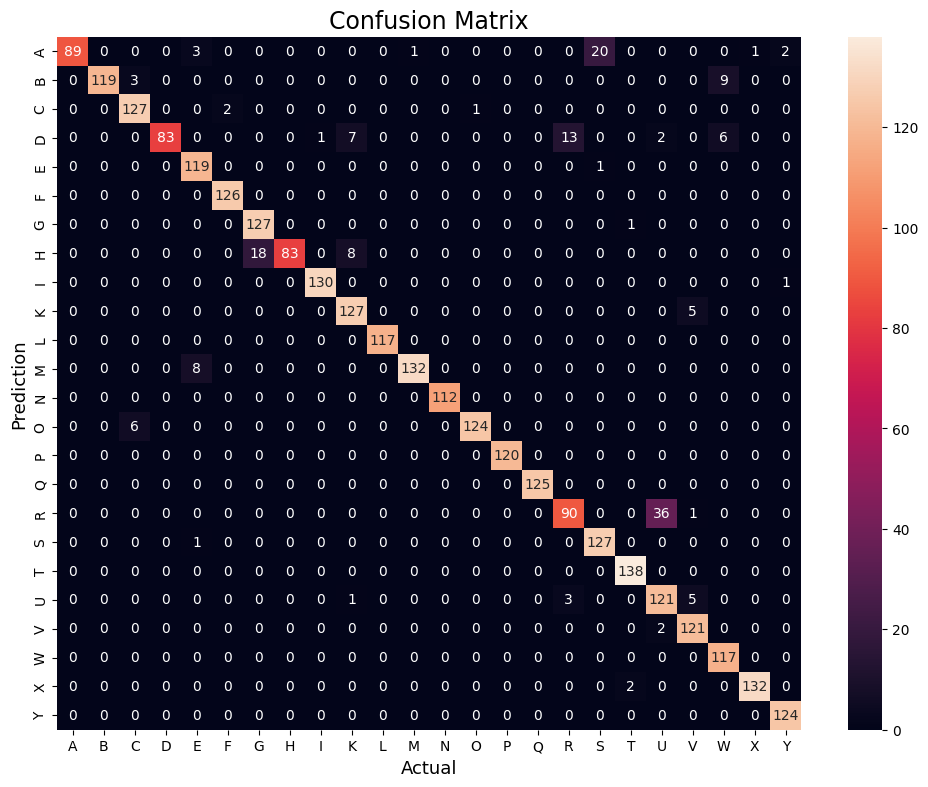

Accuracy   : 0.9433333333333334


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y"]
prediction = model.predict(X_test)
y_pred = np.argmax(prediction, axis=1)


cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix.
plt.subplots(figsize=(12, 9))

sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=labels,
            yticklabels=labels)

plt.title('Confusion Matrix',fontsize=17)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()


# Finding precision and recall
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)


# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [19]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmp7nfm_axt\assets


INFO:tensorflow:Assets written to: C:\Users\Sam\AppData\Local\Temp\tmp7nfm_axt\assets


7424

# Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 988 µs


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.7479971e-17 1.1735638e-16 1.4119798e-05 5.9238838e-21 1.0686235e-31
 3.2337722e-14 1.0904434e-01 8.3694756e-01 3.0995523e-08 1.8953080e-30
 1.1600167e-06 2.1508923e-18 5.3709710e-12 2.8448815e-06 2.5853780e-21
 6.5857814e-10 5.3996022e-22 1.0859182e-34 2.4176896e-02 1.9113860e-12
 8.5944321e-24 8.9459186e-28 2.9812995e-02 3.5103001e-25]
7
